In [28]:
%autoreload 2
%matplotlib inline

In [29]:
import pandas as pd
from astropy.io import fits

In [30]:
from astropy.coordinates import SkyCoord

In [31]:
import astropy.wcs.wcs as wcs
import matplotlib.pyplot as plt

In [32]:
from collections import OrderedDict

# Initialize data directory

In [33]:
path = "../../Data/"

# Data massaging

-[ ] combine table so we don't have to deal with several copies of the table  
-[ ] clean table according to the cuts in the Rshape catalog  
-[ ] transform image coords to WCS coords



In [34]:
dataPath = path + "Subaru_data/" 

See how to convert FITS record array to pandas dataframe for easy manipulation
in `preprocess.py`

In [35]:
bands = ["I", "R", "G"]

In [36]:
cats = OrderedDict({})
wcs_dict = OrderedDict({})
df_dict = OrderedDict({})
for band in ["I", "R", "G"]:
    cats[band] = fits.open(dataPath + "{0}.cat".format(band))
    # don't need wcs_dict if no wcs coord transformation is done
    # wcs_dict[band] = wcs.WCS(cats[band][0].header) 
    df_dict[band] = pd.read_hdf(dataPath + "preprocessed_subaru_cat.h5", 
                                band + "_data")
    df_dict[band].columns = ["{0}band_".format(band) + col 
                             for col in df_dict[band].columns]

## load Rshape catalog

In [37]:
Rshape = fits.open(dataPath + "R.shape")
Rshapes = pd.DataFrame(Rshape[1].data.tolist(),
                       columns=Rshape[1].data.dtype.names)

## see if wcs_coords tells us if the objects are the same across catalogs

In [38]:
wcs_keys = ['X_WORLD', u'Y_WORLD']

In [39]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["G"][["Gband_" + k for k in wcs_keys]])

Gband_X_WORLD   NaN
Gband_Y_WORLD   NaN
Iband_X_WORLD   NaN
Iband_Y_WORLD   NaN
dtype: float64

In [40]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["R"][["Rband_" + k for k in wcs_keys]])

Iband_X_WORLD   NaN
Iband_Y_WORLD   NaN
Rband_X_WORLD   NaN
Rband_Y_WORLD   NaN
dtype: float64

seems like the coords already show objects in the correct order

In [41]:
df_dict["I"][["Iband_" + k for k in wcs_keys]].iloc[0]

Iband_X_WORLD    268.146518
Iband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [42]:
df_dict["G"][["Gband_" + k for k in wcs_keys]].iloc[0]

Gband_X_WORLD    268.146518
Gband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [43]:
df_dict["R"][["Rband_" + k for k in wcs_keys]].iloc[0]

Rband_X_WORLD    268.146518
Rband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [44]:
for band in ["R", "G", "I"]:
    print df_dict[band].shape[0]

100680
100680
100680


seems like it is true that the objects are already aligned 

In [45]:
np.sum(df_dict["R"]["Rband_FLUX_RADIUS"] - Rshapes["FLUX_RADIUS"])

0.0

In [46]:
combined_cat = pd.concat([Rshapes, df_dict["R"], df_dict["I"], df_dict["G"]], 
                         axis=1)

# correct for magnitude zero points 

see https://github.com/MCTwo/SuprimeCam/blob/master/Reduction%20Notes/2014A_zeropoints.md
for correction values that Will found out

In [47]:
bands = [k for k in combined_cat.keys() if "_MAG_" in k]

In [48]:
correction = {"G": 27.368,
              "R": 27.683, 
              "I": 27.573}

It is ridiculous to have 99 to be in the data so we replace it.

In [49]:
combined_cat[bands] = combined_cat[bands].replace(99, np.nan)

In [50]:
for k, v in correction.iteritems():
    for bandtype in ["ISO", "APER", "AUTO"]:
        combined_cat["{0}band_MAG_{1}".format(k, bandtype)] += correction[k]

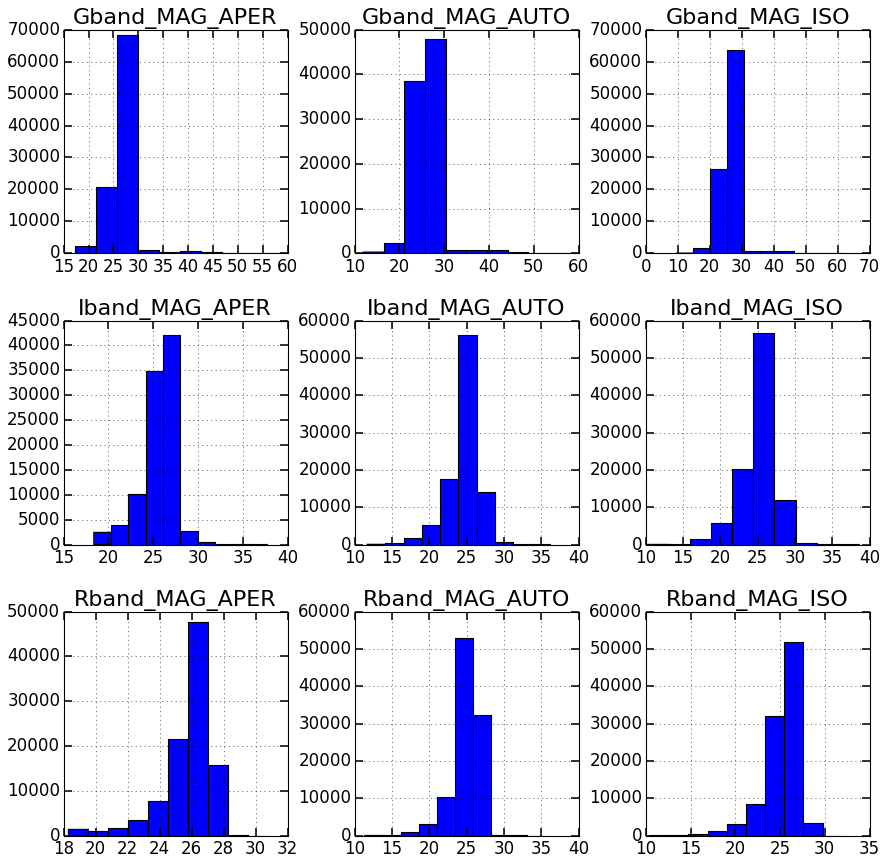

In [51]:
_ = combined_cat[bands].hist(figsize=(13, 13))

In [55]:
combined_cat[bands].describe()

,Rband_MAG_ISO,Rband_MAG_APER,Rband_MAG_AUTO,Iband_MAG_ISO,Iband_MAG_APER,Iband_MAG_AUTO,Gband_MAG_ISO,Gband_MAG_APER,Gband_MAG_AUTO
count,8892.000000,8890.000000,8805.000000,8725.000000,8707.000000,8593.000000,8618.000000,8629.000000,8277.000000
mean,25.072749,25.655562,24.785086,24.890034,25.405076,24.506141,25.834857,26.317484,25.483234
std,2.086023,1.687437,1.942807,2.343673,1.924467,2.146865,2.106003,1.770577,1.986526
min,13.072100,18.901078,12.852376,13.283464,18.832012,13.014546,13.091145,17.810831,12.627646
25%,24.197535,25.051235,24.064381,23.762522,24.565701,23.554993,24.889035,25.632227,24.689272
50%,25.590123,26.162788,25.279139,25.356534,25.883480,24.962895,26.136002,26.588435,25.767751
75%,26.550050,26.824245,26.086387,26.493636,26.664676,25.914888,27.167940,27.333606,26.650829
max,28.315028,28.833088,31.811982,35.335584,34.122338,34.483666,35.813396,34.479758,34.983976


# also do area cut!

recalculate where to cut ... ref: van Weeren 2012 Fig. 1

267.916666667 268.166666667
44.5916666667 44.7583333333


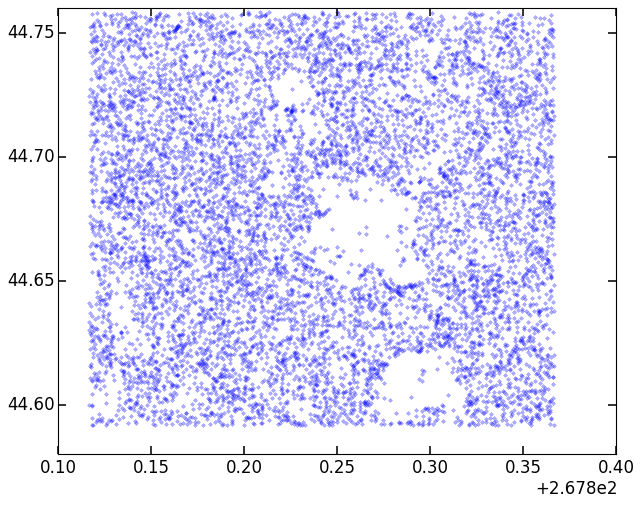

In [52]:
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")

ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_X_WORLD > ra_lower, 
        combined_cat.Rband_X_WORLD < ra_upper)]
combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_Y_WORLD > dec_lower,
        combined_cat.Rband_Y_WORLD < dec_upper)]

plt.plot(combined_cat.Rband_X_WORLD, 
         combined_cat.Rband_Y_WORLD, '.', alpha=0.3)

# save combined cat before preprocessing

In [54]:
combined_cat.to_hdf(dataPath + "combined_cat.h5", "preprocess_df")